# 📚  **MIT 15.570 Digital Marketing Analytics Final Project**



*Jiho Kil | Yushu Qiu | Jessy Lu*


# **Table of Contents**

>**Abstract**

>**Introduction**

>>**High Note's Business model**

>>**The Business Objective of High Note**

>**The High Note Data**

>>>**Installations and imports**

>>**High Note Data Dictionary**

>**Data Preprocessing**

>>**Inspection of High Note Dataset**

>>**Missing values**

>>>**Low Missing Proportion**

>>>**High Missing Proportion**

>>>**Moderate Missing Proportion**

>**Exploratory Data Analysis**

>>>**Distribution of Average Friends Age**

>>>**Difference Between Subscribers and Non-subscribers**

>**Attribution Modeling - Propensity Score Matching**

>>**The Classification Model - Logistic Regresison**

>>**Analysis of Treatment Effect: Two-proportion Z-Test**

>>**Assumptions of Propensity Score Matching**

>>>**1. Conditional Ignorability**

>>>**2. Common Support**

>>>**Propensity Score Matching with MachIt**

>>**Treatment: delta1_songsListened**

>>>**delta1_songsListened Treatment Effect**

>>**Treatment: delta1_lovedTracks**

>>>**delta1_lovedTracks Treatment Effect**

>>**Treatment: delta1_friend_cnt**

>>>**delta1_friend_cnt Treatment Effect**

>>**Treatment: delta1_friend_country_cnt**

>>>**delta1_friend_country Treatment Effect**

>>**Treatment: delta1_subscriber_friend_cnt**

>>>**delta1_subscriber_friend_cnt Treatment Effect**

>>**Treatment: delta1_shouts**

>>>**delta1_shouts Treatment Effect**

>**High Note's User Conversion Strategy**

>>>**1. Encourage Users to Listen to More Songs**

>>>**2. Nudge Users to Click the “Love” Button**

>>**3. Encourage Users to Make More Friends**

>>>**4. Facilitate Globally “Diverse” Friends**

>>>**5. Friends Subscribe, Users Subscribe**

>>>**6. More “Shouts,” More User Interactions**

>**Conclusion**



# **Abstract**


High Note's strategic initiative focuses exclusively on increasing premium subscriber numbers
through data-driven strategies to convert free users. While other revenue-driving mechanisms
exist, this analysis specifically targets understanding and discovering the conversion pathway
from free to premium subscriptions. After data analysis, we propose 6 actionable strategies that
High Note take advantage of to increase their premium subscription rate.

# **Introduction**

High Note is a company that provides digital music listening services, offering both free and premium subscription-based packages. As the final project of MIT 15.570 (Digital Marketing Analytics), our objective is to assume the role of **data analysts** and provide recommendations to the High Note CMO (Chief Marketing Officer) regarding methods to increase the number of ***premium*** subscribers, accompanied by logical justifications using the High Note dataset.

## **High Note's Business model**

High Note employs a *freemium* business model for its digital music streaming platform. The service offers a basic, free tier that allows users to create accounts, customize their profiles, and access the music library at no cost. This version is monetized through a combination of intermittent 15-second audio advertisements between tracks and strategic display advertising placements throughout the interface. In other words, the free version is used to create an audience they can sell to advertisers.

 For enhanced user experience, High Note offers a premium subscription at $3 monthly, which eliminates all advertisements and provides subscribers with exclusive additional features and functionality.



## **The Business Objective of High Note**

The primary strategic focus of High Note's current initiative centers exclusively on **increasing the number of premium subscribers**. While other revenue-driving mechanisms exist, such as pricing adjustments to influence sales and profitability metrics, these fall outside the scope of this analysis. Instead, this project's core objective is to develop and recommend data-driven strategies specifically designed to facilitate **behavioral shifts** among High Note's free-tier users, ultimately motivating their transition to premium membership status. The emphasis lies squarely on identifying and implementing effective conversion pathways from free to premium subscriptions.

# **The High Note Data**


The data for High Note's case is real and comes from an **actual online music-listening service**; however, the business situation and the 'High Note' name are fictional inventions. Due to copyright considerations, we are permitted by the instructor to present only our analytical findings and insights (this notebook) but not the raw dataset itself. The initial five rows (and some columns) of the dataset are shown below as part of the data inspection, for those interested in understanding the data structure and general composition. Please contact [professor Sinan Aral at MIT Sloan School of Management](https://www.sinanaral.io/) for inquiries regarding access to the underlying High Note Dataset.

### **Installations and imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/MIT 15.570/MIT15.570 Final Project

In [ ]:
# For missingness imputation
!pip install missforest

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

from missforest import MissForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score

random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

In [ ]:
# For R object handling in propensity score matching
pd.DataFrame.iteritems = pd.DataFrame.items
%load_ext rpy2.ipython

In [ ]:
# Read in the data for the session
high_note_raw = pd.read_excel('HighNoteDataCsv.xlsx')

## **High Note Data Dictionary**

The data contains information related to three periods:

1. **CURRENT** period spanning X months.

2. The **change** in value from the **PAST** period (three months) to the **CURRENT** (X months) period, suffixed by *delta1*

3. The **change** in values from the **CURRENT** period (X months) to the **POST** (three month) period, suffixed by *delta2*

Since *delta* values represent 'change', those variables can contain negative values. See the definitions of each feature for details.

---


**net_user**: User id

**age**: User age in the current period

**male**: If 1 then male else female

**friend_cnt**: Number of friends in the current period

**avg_friend_age**: Average age of the friends in the current period

**avg_friend_male**: What proportion of friends are male in the current period

**friend_country_cnt**: Number of different countries this user's friends are from in the current period. An indicator of how diverse the person is globally.

**subscriber_friend_cnt**: Number of friends who are premium subscribers in the current period

**songsListened**: Cumulative number of songs listened until the beginning of the current period

**lovedTracks**: Number of tracks 'loved' at the beginning of the current period

**posts**: Number of Q&A forum posts made at the start of the current period

**playlists**: Number of playlists made till the current period

**shouts**: Number of shouts received from other users till the current period. "**Shouts**" are short messages or comments that users can post on an artist's page or their own profile page within the "shoutbox" section, allowing them to share quick thoughts, reactions, or simply chat with other listeners about the music they're currently enjoying. This is an indicator of the degree of communication between users.  

**delta1_friend_cnt**: Change in the number of new friends from past to current period. For example, let’s assume a user has made 20 friends during the past period, and makes 10 new friends during the current period. Since the user made 10 less in the current period, *delta1_friend_cnt* would be -10.

**delta1_avg_friend_age**: Change in the average age of new friends made from past to current period. For example, let’s assume a user has made 20 friends during the past period and the average age of these 20 friends is 26.5. If she makes 10 new friends during the current period and the *avg_friend_age* of these 30 friends is 20, then *delta1_avg_friend_age* would be -6.5.

**delta1_avg_friend_male**: Change in the proportion of friends who are male from past to current period. For example, if the proportion of male friends in the past period was 0.5 and the proportion of male friends in the current period was 0.3, then *delta1_avg_friend_male* would be -0.2.

**delta1_friend_country_cnt**: Change in the number of different countries of the users' new friends from past to current period. For example, if the user's new friends in the past period were from 5 different countries, and the users' new friends in the current period were from 3 different countries in the current period, then *delta1_friend_country_cnt* would be -2.

**delta1_subscriber_friend_cnt**: Change in the number of new friends who are premium subscribers from past to current period. For example if a user has made 5 new friends who are subscribers during the past period, and makes 2 new friends who are subscribers during the current period. then *delta1_subscriber_friend_cnt* would be -3.

**delta1_songsListened**: Change in the number of new songs listened to from past to current period. For example, if a user had listened to 10 new songs during the past period, but only listened to 3 new songs during the the current period, then *delta1_songsListened* would be -7.

**delta1_lovedTracks**: Change in the number of new tracks loved from past to current period. For example, if the user had loved 10 new tracks during the past period, but only loved 7 new tracks loved in the current period, then *delta1_lovedTracks* would be -3.

**delta1_posts**: Change in the number of new posts made from past to current period. For example, if the user made 10 new posts during the past period, but made 7 new posts during the current period, then *delta1_posts* would be -3.

**delta1_playlists** Change in the number of of new playlists from past to current period. For example, if the user made 10 new playlists during the past period, but created 7 new playlists during the current period, then *delta1_playlists* would be -3.

**delta1_shouts**: Change in the number of new shouts received from others from past to current period. For example, if the user received 10 new shouts during the past period, but received 7 new shouts during the current period, then *delta1_shouts* would be -3.

**adopter**: 1 if the user switched from being FREE to PREMIUM subscriber at the end of the CURRENT period

**tenure**: How long has the user been on the site (in months)

**good_country**:  1 if from US, UK or Germany, else 0

**delta1_good_country**: Did the user move from / into good country in the current period compared to past? 1: The user moved TO a "good" country, 0: No change in country status (either stayed in good country or stayed in non-good country), -1: The user moved FROM a "good" country

**delta2_friend_cnt**: Change in the number of new friends from current to post period.

**delta2_avg_friend_age**: Change in the average age of new friends made from current to post period.

**delta2_avg_friend_male**: Change in the proportion of friends who are male from current to post period.

**delta2_friend_country_cnt**: Change in the number of different countries of the users' new friends from current to post period.

**delta2_subscriber_friend_cnt**: Change in the number of new friends who are premium subscribers from current to post period.

**delta2_songsListened**: Change in the number of new songs listened to from current to post period.

**delta2_lovedTracks**: Change in the number of new tracks loved from current to post period.

**delta2_posts**: Change in the number of new posts made from current to post period.

**delta2_playlists**: Change in the number of of new playlists from current to post period.

**delta2_shouts**:Change in the number of new shouts received from others from current to post period.

**delta2_good_country**: 1 = Did the user move from / into good country in the post period compared to current?


# **Data Preprocessing**

## **Inspection of High Note Dataset**

Initial inspection into the first five rows already shows some missing values present, which implies the need to systematically address the missingness in the data. The data summary indicates that besides the `net_user` feature, all features are numerical variables, some already having been encoded from categorical outcomes.

In [ ]:
# A preview into the high_note data
high_note_raw.head()

,net_user,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta2_avg_friend_age,delta2_avg_friend_male,delta2_friend_country_cnt,delta2_subscriber_friend_cnt,delta2_songsListened,delta2_lovedTracks,delta2_posts,delta2_playlists,delta2_shouts,delta2_good_country
0,tinaj5920,NaN,0.0,20.0,30.285714,0.736842,14.0,1.0,8414,348,...,0.357143,0.0,1.0,1.0,159.0,1.0,0.0,0.0,NaN,0.0
1,tinalabina,NaN,NaN,3.0,30.500000,0.333333,1.0,0.0,1943,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,tinamachine,22.0,0.0,8.0,22.571429,0.428571,1.0,0.0,9687,194,...,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,tinamarriott,31.0,0.0,0.0,NaN,NaN,0.0,0.0,26863,12,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,tinamausiii,NaN,NaN,1.0,NaN,1.000000,1.0,0.0,187,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [ ]:
# Summary of high_note data
high_note_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107213 entries, 0 to 107212
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   net_user                      107204 non-null  object 
 1   age                           56354 non-null   float64
 2   male                          68263 non-null   float64
 3   friend_cnt                    107212 non-null  float64
 4   avg_friend_age                85587 non-null   float64
 5   avg_friend_male               90696 non-null   float64
 6   friend_country_cnt            107212 non-null  float64
 7   subscriber_friend_cnt         107212 non-null  float64
 8   songsListened                 107213 non-null  int64  
 9   lovedTracks                   107213 non-null  int64  
 10  posts                         107213 non-null  int64  
 11  playlists                     107213 non-null  int64  
 12  shouts                        105286 non-nul

## **Missing values**

This section deals with the missing values in our data. First, we check the number of missing values for each column (only for those where missing values exist), as well as the percentage of those missing values relative to the entire sample size.

In [ ]:
# Check for missing values
print("\n=== Missing Values Analysis ===")
missing_values = high_note_raw.isnull().sum()
missing_pct = (high_note_raw.isnull().sum() / len(high_note_raw)) * 100

missing_analysis = pd.DataFrame({
    'Number of Missing Values': missing_values,
    'Percentage Missing': missing_pct
})
display(missing_analysis[missing_analysis['Number of Missing Values'] > 0])


=== Missing Values Analysis ===


,Number of Missing Values,Percentage Missing
net_user,9,0.008395
age,50859,47.437344
male,38950,36.329550
friend_cnt,1,0.000933
avg_friend_age,21626,20.171061
avg_friend_male,16517,15.405781
friend_country_cnt,1,0.000933
subscriber_friend_cnt,1,0.000933
shouts,1927,1.797357
delta1_friend_cnt,26,0.024251


The data examination reveals the presence of missing values across multiple variables in the dataset. This widespread occurrence of incomplete data points necessitates a comprehensive missing data strategy and careful consideration of appropriate imputation methods to ensure the robustness and reliability of our subsequent analyses.

We classified the variables into three categories based on the **proportion of missing values**. For each category, we implemented different methodological frameworks to address the data gaps in an attempt to maximize optimal data quality while maintaining analytical integrity:

- **Low Missing Proportion (<5%)**: Use simple mean or median imputation to fill in missing values. Using simple imputation for small proportion of missing values minimizes the risk of introducing significant bias, and preserves the overall distribution characteristics of the data.

- **Moderate Missing Proportion (5%-40%)**: Apply iterative imputation method based on Random Forest to estimate missing values, assuming that the values are Missing At Radom (MAR), meaning that the missingness is related to the features existing in the dataset. Since there is much more missingness present compared to the low proportion category, simple imputation methods would introduce too much bias, while there remains sufficient observed data to learn meaningful relationships between variables. This makes the Random Forest imputation method optimal, as they can leverage these learned relationships to generate more accurate predictions while properly accounting for uncertainty in the imputed values through its ensamble mechanism.


- **High Missing Proportion (>40%)**: Drop columns with a high proportion of missing values. The high proportion of missing values makes any kind of imputation potentially unreliable, and we determined that the risk of introducing significant bias through imputation outweighs its potential benefits.

### **Low Missing Proportion**

We used the median for the simple imputation due to its robustness to outliers and skewed distributions.

In [ ]:
# Check the features that belong to the low missing proportion
low_missing_prop = missing_analysis[missing_analysis['Percentage Missing'] < 5]
low_missing_prop

,Number of Missing Values,Percentage Missing
net_user,9,0.008395
friend_cnt,1,0.000933
friend_country_cnt,1,0.000933
subscriber_friend_cnt,1,0.000933
songsListened,0,0.000000
lovedTracks,0,0.000000
posts,0,0.000000
playlists,0,0.000000
shouts,1927,1.797357
delta1_friend_cnt,26,0.024251


In [ ]:
# Get the column names from low_missing_prop that need imputation
# net_user is user name that we won't put into our model, so ignore it
columns_to_impute = low_missing_prop.index[1:]
for col in columns_to_impute:
      # Calculate the median of the current column
      median_value = high_note_raw[col].median()

      # Impute the median value for all missing values in the current column
      high_note_raw[col].fillna(median_value, inplace=True)

### **High Missing Proportion**

For some reason, *delta2_shouts* did not contain any data. Therefore, it was dropped along with *age*. We additionally dropped the *net_user* feature, because *net_user* represents the user ID, which would not be used in our analysis.

In [ ]:
# Check the features that belong to the high missing proportion
high_missing_prop = missing_analysis[missing_analysis['Percentage Missing'] > 40]
high_missing_prop

,Number of Missing Values,Percentage Missing
age,50859,47.437344
delta2_shouts,107213,100.000000


Furthermore, we find that there is a high correlation between the *age* and *avg_friend_age* for existing data, indicating that it would be possible (and safer) to infer information about user age through *avg_friend_age* than to impute the *age* variable, where half of the values are missing.

In [ ]:
# Correlation between age and avg_friend_age
corr_age_friendage = round(high_note_raw['age'].corr(high_note_raw['avg_friend_age']), 1)
print(f'Correlation: {corr_age_friendage}')

Correlation: 0.7


In [ ]:
# RMSE between age and avg_friend_age
# We see that the average age of friends does not deviate severely from the user age.
ages = high_note_raw[['age', 'avg_friend_age']].dropna()
rmse_age_friendage = round(np.sqrt(mean_squared_error(ages['age'], ages['avg_friend_age'])), 2)
print(f'RMSE: {rmse_age_friendage} years')

RMSE: 4.88 years


In [ ]:
# Drop the columns age, delta2_shouts, and net_user
high_note_raw = high_note_raw.drop(columns=list(high_missing_prop.index) + ['net_user'])

### **Moderate Missing Proportion**

We use MissForest, which is a non-parametric, iterative imputation method based on random forests. MissForest is suitable as it can capture complex non-linear relationships and interactions between variables without making assumptions about data distributions, while its ensemble nature inherently accounts for uncertainty in the imputed values.

In [ ]:
# Check the features that belong to the moderate missing proportion
moderate_missing_prop = missing_analysis[(missing_analysis['Percentage Missing'] >= 5) & (missing_analysis['Percentage Missing'] <= 40)]
moderate_missing_prop

,Number of Missing Values,Percentage Missing
male,38950,36.329550
avg_friend_age,21626,20.171061
avg_friend_male,16517,15.405781
delta1_avg_friend_age,22057,20.573065
delta1_avg_friend_male,16826,15.693992
good_country,39155,36.520758
delta1_good_country,39393,36.742746
delta2_avg_friend_age,21843,20.373462
delta2_avg_friend_male,16803,15.672540
delta2_good_country,38960,36.338877


In [ ]:
# Convert Int64 columns to float for imputation
int_cols_list = high_note_raw.select_dtypes(include=['Int64']).columns
high_note_raw[int_cols_list] = high_note_raw[int_cols_list].astype('float64')

In [ ]:
# Columns to impute
moderate_missing_cols = moderate_missing_prop.index

# Use Missforest to impute
missforest_imputer = MissForest(max_iter=10)
high_note_raw_imputed = missforest_imputer.fit_transform(high_note_raw.drop(['adopter'], axis=1))

# Replace the values back to our dataset
high_note_raw[moderate_missing_cols] = high_note_raw_imputed[moderate_missing_cols]

# Inspect the result
high_note_raw[moderate_missing_cols].head()

100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


,male,avg_friend_age,avg_friend_male,delta1_avg_friend_age,delta1_avg_friend_male,good_country,delta1_good_country,delta2_avg_friend_age,delta2_avg_friend_male,delta2_good_country
0,0.000000,30.285714,0.736842,0.619048,-0.013158,1.000000,0.000000,0.357143,0.000000,0.000000
1,0.506234,30.500000,0.333333,3.500000,-0.166667,0.001551,-0.000343,0.000000,0.000000,0.000176
2,0.000000,22.571429,0.428571,0.000000,0.000000,1.000000,0.000000,0.571429,0.000000,0.000000
3,0.000000,23.818213,0.610606,0.196687,-0.000206,0.000000,0.000000,0.236553,0.000233,0.000000
4,0.502489,24.363070,1.000000,0.219629,0.000000,0.059548,0.000637,0.267688,0.000000,0.000158


In [ ]:
# Transform binary fieleds to meaningful values (only 0 or 1, not any value between)
binary_columns = ['male', 'good_country']
high_note_raw[binary_columns] = high_note_raw[binary_columns] > 0.5

# Transform categorical fieleds to meaningful values (-1, 0, 1)
categorical_columns = ['delta1_good_country', 'delta2_good_country']
high_note_raw[categorical_columns] = high_note_raw[categorical_columns].apply(
    lambda x: np.where(x >= 0.5, 1, np.where((x > -0.5) & (x < 0.5), 0, -1)))
high_note_raw = high_note_raw.astype('float64')

print('\nHigh note binary columns:')
display(high_note_raw[binary_columns].head(5))
print('\nHigh note categorical columns:')
display(high_note_raw[categorical_columns].head(5))


High note binary columns:


,male,good_country
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,0.0
4,1.0,0.0



High note categorical columns:


,delta1_good_country,delta2_good_country
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [ ]:
# Check that there are no more missing values
high_note_raw.isnull().sum().sum() == 0

True

# **Exploratory Data Analysis**


For EDA, we focus on the current dimensional variables rather than the 'delta' features in order to understand the general characteristics of users and discover meaningful patterns within the users.

In [ ]:
# Use the characeristic columns
high_note_current = high_note_raw.loc[:, ~high_note_raw.columns.str.startswith(('delta1', 'delta2'))]
high_note_current.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,shouts,adopter,tenure,good_country
0,0.0,20.0,30.285714,0.736842,14.0,1.0,8414.0,348.0,0.0,1.0,6.0,0.0,59.0,1.0
1,1.0,3.0,30.500000,0.333333,1.0,0.0,1943.0,0.0,0.0,0.0,3.0,0.0,34.0,0.0
2,0.0,8.0,22.571429,0.428571,1.0,0.0,9687.0,194.0,0.0,1.0,8.0,0.0,59.0,1.0
3,0.0,0.0,23.818213,0.610606,0.0,0.0,26863.0,12.0,0.0,0.0,2.0,0.0,55.0,0.0
4,1.0,1.0,24.363070,1.000000,1.0,0.0,187.0,0.0,0.0,0.0,7.0,0.0,52.0,0.0


### **Distribution of Average Friends Age**

We observe that most of the users enjoying the service of High Note are **young** users, within the range of 20s and 30s. This can prompt the company to consider strategies mainly geared towards the younger generation.

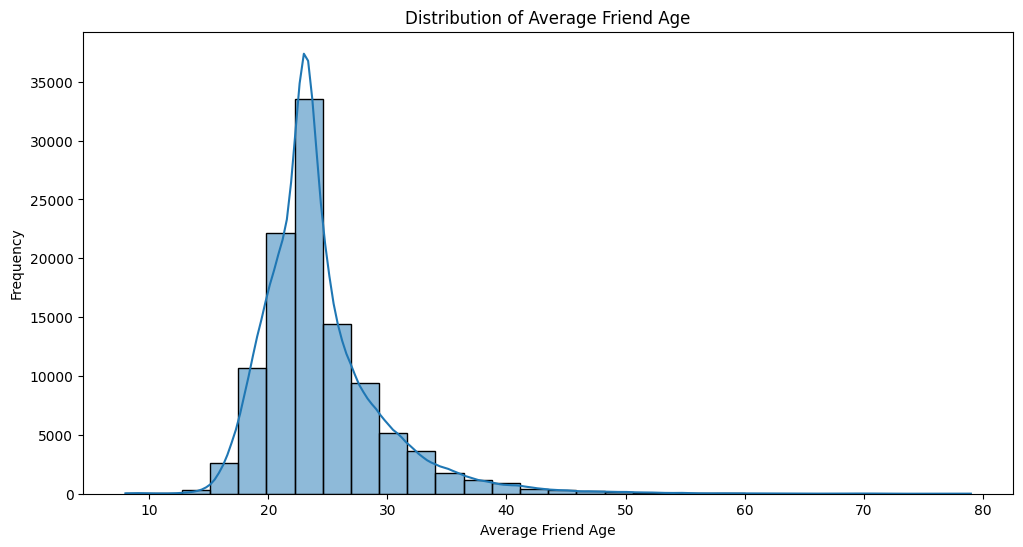

In [ ]:
# Distribution plot for average friend age
plt.figure(figsize=(12, 6))
sns.histplot(high_note_current['avg_friend_age'], bins=30, kde=True)
plt.title('Distribution of Average Friend Age')
plt.xlabel('Average Friend Age')
plt.ylabel('Frequency')
plt.show()

### **Difference Between Subscribers and Non-subscribers**

We inspected whether there is a differernce in the characteristics between free users and subscribers by comparing the mean values of the two groups.
There was an immensely large scale difference between the *songsListened* feature and the rest of the features, which made it difficult to visualize the comparisons within a single plot. Therefore, we used the log y-scale to ensure that we could compare the free users against subscribers across all current features.

It can be noticed that a pattern exists, which is that subscribers had a higher value for each characteristic against non-subscribers. On average, Subscribers had more friends, from more diverse countries, more 'subscriber' friends, listened to more songs, loved more tracks, made more Q&A posts and received more shouts. This is a clear and interesting trend, which necessitates further steps to validate whether this difference is systematic. For features that High Note can directly or indirectly nudge to change the behavior of users, we decided that it is appropriate to go through an attribution modeling procedure to see whether certain features of interest can causally influence the free users to convert to premium subscription.

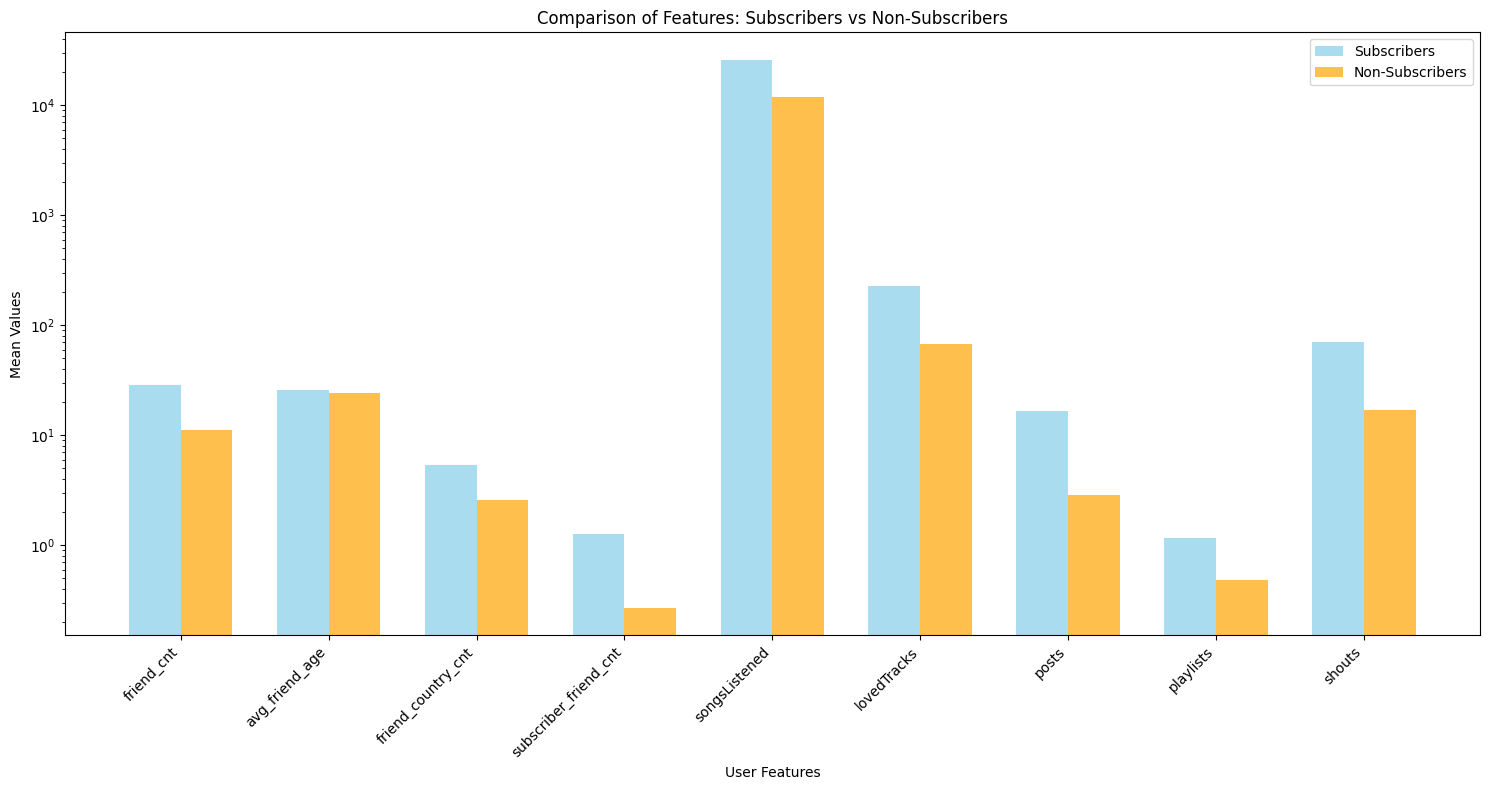

In [ ]:
# Difference between subscribers and non-subscribers
plt.figure(figsize=(15, 8))

# List of current features to compare
current_features = ['friend_cnt', 'avg_friend_age', 'friend_country_cnt',
           'subscriber_friend_cnt', 'songsListened', 'lovedTracks',
           'posts', 'playlists', 'shouts']


# Calculate means for adopters and non-adopters
adopter_means = high_note_current[high_note_current['adopter'] == 1][current_features].mean()
non_adopter_means = high_note_current[high_note_current['adopter'] == 0][current_features].mean()

# Set up bar positions
x = np.arange(len(current_features))
width = 0.35

# Create bars
plt.bar(x - width/2, adopter_means, width, label='Subscribers', color='skyblue', alpha=0.7)
plt.bar(x + width/2, non_adopter_means, width, label='Non-Subscribers', color='orange', alpha=0.7)

# Customize the plot
plt.xlabel('User Features')
plt.ylabel('Mean Values')
plt.title('Comparison of Features: Subscribers vs Non-Subscribers')
plt.xticks(x, current_features, rotation=45, ha='right')
plt.legend()

# Log scale to clearly see the bars and differences regardless of scale
plt.yscale('log')

plt.tight_layout()
plt.show()

# **Attribution Modeling - Propensity Score Matching**

**Propensity Score Matching (PSM)** is an observational analytical technique used to estimate the *causal effect* of a treatment by using available features in the data. It involves using an underlying classification model to calculate propensity scores for each unit (e.g. individual), which is the probability of the unit receiving the treatment given its observed characteristics. Units in the treatment and control groups with similar propensity scores are then matched to create comparable *Treatment* and *Control* groups, *mimicking* a randomized experiment. PSM is an excellent alternative to A/B testing when experimental setups (randomization) is not feasible due to constraints, as it helps reduce selection bias (meaning that both groups do not have systematic differences on all relevant conditions or characteristics, except for the treatment itself) and balances features between groups, allowing researchers to infer **causal relationships** while leveraging existing data.

The primary objective of this section is to identify the actions or situations that may drive an increase in conversions to the premium subscription. Since these insights will inform High Note’s future business strategies, the treatment variables should be ones that High Note can influence, either directly or indirectly. This criterion, along with the results from the previous EDA, is used to select appropriate treatment candidates from the data for propensity score matching.

## **The Classification Model - Logistic Regresison**

For the underlying classification model that creates the propensity scores, We used the Logistic Regression model, which is the default model used for propensity score matching. The advantage of logistic regression lies in its simplicity, interpretability, and computational efficiency, making it a good choice for for propensity score estimation. While more complex models might  improve performance, we explain below why predictive performance is not the main goal in this section.

For the matching, we chose all features except the ones that were already dropped and the *delta2* variables. We decided that excluding the post-period variables from the propensity score matching model is a more appropriate choice for our analysis, as these variables reflect information that is available only after the outcome of interest (the ***adopter*** variable, which represents conversion to premium in the CURRENT period) has occurred. Including post-period features could introduce post-treatment bias, where the post-period variables that could have been influenced by the outcome are used for the assignment of Treatment/Control, possibly distorting the matching process. To ensure a valid causal inference, we determined that it would be safer to base the matching process only on features available before or during the period of the outcome.


Below, we define a function which takes in the dataset and the treatment variable and returns the AUC (Area Under the Curve), which is a classification metric. AUC is ideal for assessing propensity score models because it measures how well the model’s ranking of units by their probability of receiving treatment corresponds to the actual treatment assignments. This aligns with propensity score matching's goal of finding similar units with different treatment statuses, where we care about the relative ordering of propensity scores and hope for moderate discrimination between treated and control units.

The model needs to have 'sufficient' (but not too perfect) discriminative power to ensure that not only the propensity scores reflect the true probability of receiving treatment based on covariates, but also that units with similar propensity scores exist in both treatment and control. This is because in propensity score matching, units with similar propensity scores are considered to have similar characteristics in terms of the observed covariates, and it is necessary for those with similar characteristics to exist in both treatment and control for an unbiased comparison (**common support** assumption).

If the AUC is too high (>0.9), it suggests the model is too good at separating treated and control units, meaning there might be little overlap in propensity scores between the groups, potentially violating the common support assumption. Conversely, if the AUC is too low (<0.6), the model isn't capturing meaningful differences in treatment assignment patterns, potentially leading to inadequate propensity scores. Therefore, A moderate AUC (typically in the range of 0.6-0.8) generally indicates there's enough discriminative power in the model for us to use propensity scores as a representation of user characteristics while maintaining sufficient overlap between treatment and control groups for valid matching.

In [ ]:
# Use all columns except delta2
high_note = high_note_raw.loc[:, ~high_note_raw.columns.str.startswith('delta2')]
high_note.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_subscriber_friend_cnt,delta1_songsListened,delta1_lovedTracks,delta1_posts,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country
0,0.0,20.0,30.285714,0.736842,14.0,1.0,8414.0,348.0,0.0,1.0,...,-1.0,2918.0,60.0,0.0,0.0,0.0,0.0,59.0,1.0,0.0
1,1.0,3.0,30.500000,0.333333,1.0,0.0,1943.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0
2,0.0,8.0,22.571429,0.428571,1.0,0.0,9687.0,194.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,1.0,0.0
3,0.0,0.0,23.818213,0.610606,0.0,0.0,26863.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0
4,1.0,1.0,24.363070,1.000000,1.0,0.0,187.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0


Given the presence of substantial correlations among some predictor variables in our dataset, LASSO regularization was implemented in the logistic regression model as our feature selection approach. Since our primary objective is to obtain reliable propensity scores for matching rather than specific model interpretation or inference about certain feature effects, we determined that implementing LASSO regularization would present an appropriate solution. The strong penalty term addresses potential model instability due to correlated features through automated variable selection, while preserving the model's capacity to generate valid propensity scores for subsequent matching procedures.

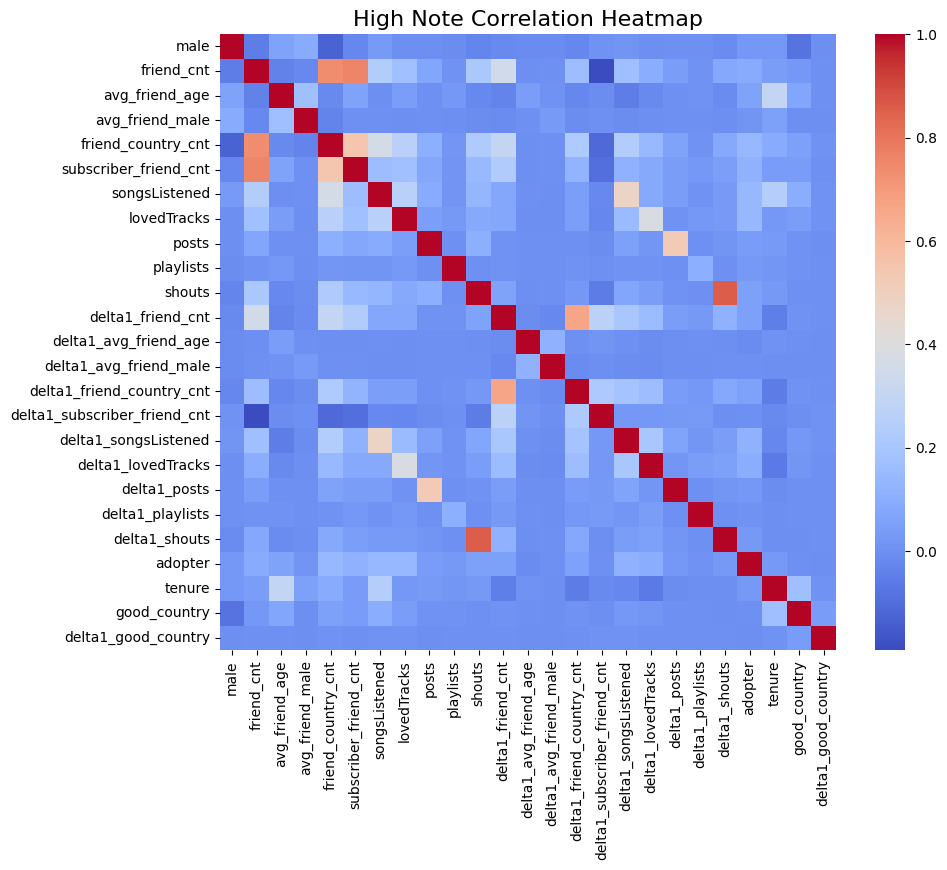

In [ ]:
# Calculate the correlation matrix of high_note
# It can be observed that some features are correlated
correlation_matrix = high_note.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    cbar=True,
    square=True
)

plt.title("High Note Correlation Heatmap", fontsize=16)
plt.show()

We defined some helper functions below that are used to assess underlying model performance and compare the propensity score distribution between treatment and control. These series of functions are used for each of our treatment variables to understand the matching result and gauge the causal effect on outcome.

In [ ]:
# Helper function - inspect auc
def propensity_model_auc(data, treatment, **lasso_params):
    """
    Trains a LASSO Logistic Regression model for propensity score estimation and returns AUC.

    Parameters:
    data (pd.DataFrame): The feature dataset (excluding treatment variable)
    treatment (pd.Series): The treatment assignment variable (0/1)

    **lasso_params: Keyword arguments for LogisticRegression parameters
                   e.g., C (inverse of regularization strength), max_iter, etc.
    """
    # Default parameters for LASSO Logistic Regression
    default_params = {
        'random_state': 42,
        'penalty': 'l1',    # LASSO penalty
        'solver': 'liblinear',
        'C': 0.00001         # Inverse of regularization strength
    }

    # Update default parameters with any provided parameters
    default_params.update(lasso_params)

    # Initialize the LASSO Logistic Regression with specified parameters
    lasso = LogisticRegression(**default_params)

    # Fit the model
    lasso.fit(data, treatment)

    # Get predicted probabilities for treatment assignment
    pred_probs = lasso.predict_proba(data)[:, 1]

    # Calculate and return AUC
    auc = roc_auc_score(treatment, pred_probs)

    return "AUC: " + str(round(auc, 2))


def plot_propensity_distribution(matched_df, treatment):
    """
    Creates a KDE plot comparing propensity score distributions for treated and control groups.

    Parameters:
    matched_df (DataFrame): The matched dataset
    treatment_col (str): Name of the treatment column
    """

    # Split data into treatment and control
    matched_T = matched_df[matched_df[treatment]==1]
    matched_C = matched_df[matched_df[treatment]==0]

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Treatment group distribution
    sns.kdeplot(data=matched_T['distance'],
                fill=True,
                alpha=0.3,
                color='blue',
                linewidth=2)

    # Control group distribution
    sns.kdeplot(data=matched_C['distance'],
                fill=True,
                alpha=0.3,
                color='orange',
                linewidth=2)

    # Customize the plot
    plt.title(f'Distribution of Propensity Scores\n({treatment})')
    plt.xlim(0, 1)
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.legend(['Treated', 'Control'])

    # Show the plot
    plt.show()

## **Analysis of Treatment Effect: Two-proportion Z-Test**


Estimation of treatment effect is performed after propensity score matching to ultimately determine the causal effect of a particular treatment on outcome. We defined a helper function that is applied to the matched dataset, going through the following steps:


**Basic Treatment Effect Calculation**
- Calculates mean outcomes for treatment and control groups separately.
- Computes the Average Treatment Effect (ATE) as the difference between these means.
- To calculate the ATE, we first find the mean of the outcome variable ('adopter') separately for treatment and control. These represent the proportion of subscribers for each group. The ATE is then simply computed as the difference between these two proportions (*treatment_mean* - *control_mean*).


**Two-Proportion Z-Test Execution**
The test evaluates whether the difference between the two proportions from independent samples are statistically significant.

Let:
- $p_1$ = proportion in treatment group
- $p_2$ = proportion in control group
- $n_1$ = treatment group size
- $n_2$ = control group size

The test statistic is:

$$Z = \frac{p₁ - p₂}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n₁} + \frac{1}{n₂})}}$$

where $\hat{p}$ is the pooled proportion:

$$\hat{p} = \frac{x₁ + x₂}{n₁ + n₂}$$

(x₁ and x₂ are subscriber counts in each group)

The null hypothesis (H₀) is that the two proportions are equal:

$$H_0: p_1 = p_2$$

$$H_1: p_1 ≠ p_2$$


If the p-value < 0.05, we reject the null hypothesis, indicating a significant treatment effect.

In [ ]:
# Helper function - analyze treatment effect
def analyze_treatment_effect(matched_df, treatment):
    """
    Analyze treatment effect in matched data using two-proportion z-test

    Parameters:
    matched_df (DataFrame): The matched dataset
    treatment (str): Name of the treatment column
    """
    # Basic Difference in Proportions
    treat_mean = matched_df[matched_df[treatment]==1]['adopter'].mean()
    control_mean = matched_df[matched_df[treatment]==0]['adopter'].mean()
    ate = treat_mean - control_mean

    # Z-test for proportions
    treat_count = matched_df[matched_df[treatment]==1]['adopter'].sum()
    control_count = matched_df[matched_df[treatment]==0]['adopter'].sum()
    treat_size = len(matched_df[matched_df[treatment]==1])
    control_size = len(matched_df[matched_df[treatment]==0])

    count = np.array([treat_count, control_count])
    nobs = np.array([treat_size, control_size])

    z_stat, p_value_z = proportions_ztest(count, nobs)

    # Print results
    print("\nTreatment Effect Analysis:")
    print("--------------------------")
    print(f"Treatment group mean: {treat_mean:.4f}")
    print(f"Control group mean: {control_mean:.4f}")
    print(f"Average Treatment Effect (ATE): {ate:.4f}")
    print(f"\nStatistical Test:")
    print(f"Z-test p-value: {p_value_z:.7f}")
    if p_value_z < 0.05:
        print("There is a significant difference between the treatment and control groups (p < 0.05).")
        print(f"The treatment group has a {abs(ate*100):.1f} percentage point {'higher' if ate > 0 else 'lower'} conversion rate.")
    else:
        print("There is no evidence of significant difference between the treatment and control groups (p ≥ 0.05).")

    return {
        'Treatment group conversion rate': round(treat_mean, 2),
        'Control group conversion rate': round(control_mean, 2),
        'Average Treatment Effect (ATE)': ate,
        'z_stat': z_stat,
        'p_value_z': p_value_z,
    }


def plot_treatment_effect(matched_df, treatment):
    """
    Visualize treatment effect between treatment and control

    Parameters:
    matched_df (DataFrame): The matched dataset
    treatment (str): Name of the treatment column
    """
    plt.figure(figsize=(10, 6))

    # Calculate proportions for each group
    props = matched_df.groupby(treatment)['adopter'].mean()
    print("Props Series:")
    display(props)

    # Calculate standard errors for each group
    sems = matched_df.groupby(treatment)['adopter'].sem()
    print("Sems Series:")
    display(sems)

    # Create bar plot with standard errors
    plt.bar(['Control', 'Treatment'], [props[0], props[1]],
            yerr=sems,  # Standard errors
            capsize=5)

    plt.title(f'Treatment Effect on Conversion\n({treatment})')
    plt.ylabel('Proportion of Adopters')
    plt.ylim(0, 0.35)

    # Add the ATE
    ate = props[1] - props[0]
    plt.text(0.5, max(props) + 0.03,
             f'ATE = {ate:.4f}',
             horizontalalignment='center')

    plt.show()

## **Assumptions of Propensity Score Matching**

### **1. Conditional Ignorability**

**Conditional Ignorability** means that, after conditioning on the observed covariates, the treatment is 'as if' randomly assigned. In other words, for units with **similar propensity scores**, there should be no unobserved systematic differences between treated and control units that could affect the outcome except for treatment. The idea is that units with similar propensity scores have similar characteristics, both observed and unobserved, so that any remaining differences in the outcomes can be attributed to treatment rather than to confounding factors.


### **2. Common Support**

**Common Support** states that there should be overlap in the propensity score distributions of the treatment and control groups, meaning that for each unit in the treatment group, there should be one or more units in the control group with a **similar propensity score**, and vice versa. This is a practical assumption necessary for propensity score matching to work effectively, because if there is no overlap, we cannot find appropriate matches for all treated and control units. When the conditional support assumption is violated, we cannot find proper matches for treated or control units because there are no similar units in the opposite group. Forcing matches between dissimilar units could lead to biased treatment effect estimates, which is far from ideal. We can only make valid causal inferences for subpopulations where both treated and control units with similar characteristics exist. This can be validated, which is part of the next phase of the analysis.

### **Propensity Score Matching with MachIt**

We used R's MatchIt for the propensity score matching process. MatchIt stands out as the best choice for propensity score matching due to its comprehensive availabilty of matching methods and robust diagnostics post-matching. While Python libraries for propensity score matching fo exist, we realized they lack the methodological sophistication and diagnostic capabilities that MatchIt offers.

The steps for our propensity score matching and the subsequent analysis operate as follows:

**Initial Propensity Score Calculation:**
   - A logistic regression model (with the configured hyperparameters) estimates the probability (propensity score) of each unit receiving the treatment based on their covariates

**Nearest Neighbor Matching (method = "nearest") and Caliper (caliper = 0.1):**
   - For each treated unit, the algorithm selects the nearest available control unit within the 0.1 standard deviations of the propensity score distribution. "Nearest" means the smallest absolute difference in propensity scores.
   - This ensures that only the close matches (units with similar propensity scores) remain for analysis.

**One-to-One Matching (ratio = 1):**
   - Each treated unit is matched to exactly one control unit.

This process results in a smaller dataset with two groups (treatment, control) of equal size that are considered suitable for subsequent causal analysis.



## **Treatment: delta1_songsListened**

The *delta1_songsListened* feature represents the change in the number of new songs listened to from past to current period. If *delta1_songsListened* = 3, it means the user listened to three more new songs in the current period compared to the past. If *delta1_songsListened* = -3, it means the user listened to three less new songs in the current period compared to the past.

Therefore,

If **delta1** > 0, it represents users who increased their song discovery rate at High Note, indicating active exploration and engagement with the platform's music content

If **delta1** ≤ 0, it represents users who maintained or decreased their song discovery rate at High Note, indicating declining engagement with the music content.

In [ ]:
# Make a copy of High Note Dataset
high_note_songsListened = high_note.copy()

# Create a binary variable
high_note_songsListened['active_song_listened'] = (high_note_songsListened['delta1_songsListened'] > 0).astype(int)

# Drop the 'delta1_songsListened' variable and store into hn_songsListened_match
# This will be used for the matching process
hn_songsListened_match = high_note_songsListened.drop('delta1_songsListened', axis=1)

# Drop both the 'delta1_songsListened' variable and 'adopter' variable, store into hn_songsListened
# This is used for preliminary training and AUC inspection
hn_songsListened = high_note_songsListened.drop(['delta1_songsListened', 'adopter'], axis=1)

# Split Treatment from data
songsListened_data = hn_songsListened.drop('active_song_listened', axis=1)
songsListened_treatment = hn_songsListened['active_song_listened']

In [ ]:
# Train the LR model and inspect the AUC
propensity_model_auc(songsListened_data, songsListened_treatment)

'AUC: 0.82'

In [ ]:
%%R
# Install R packages for propensity score matching
install.packages('glmnet')
install.packages('MatchIt')

In [ ]:
%%R -i hn_songsListened_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_song_listened ~ . - adopter,
                      data = hn_songsListened_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_songsListened = match.data(matchprocess)
write.csv(matched_songsListened,"matched_songsListened.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_song_listened ~ . - adopter, data = hn_songsListened_match, 
    method = "nearest", distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.6001        0.2573          1.1958
male                                0.7432        0.7154          0.0636
friend_cnt                         22.3802        5.7034          0.2464
avg_friend_age                     23.9061       24.6870         -0.1673
avg_friend_male                     0.6389        0.6334          0.0214
friend_country_cnt                  4.3437        1.7873          0.3800
subscriber_friend_cnt               0.6420        0.1373          0.1675
songsListened                   24174.8341     5587.7096          0.5650
lovedTracks                       142.0285       36.4241          0.308

After matching, there were 22389 pairs available, with an average propensity score being 0.40 for treatment and 0.39 for control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_songsListened = pd.read_csv('matched_songsListened.csv')
matched_songsListened.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country,active_song_listened,distance,weights,subclass
0,0,0,23.818213,0.610606,0,0,26863.0,12,0,0,...,0,0,0,55,0,0,0,0.367536,1,3632
1,1,3,26.666667,0.000000,2,0,371.0,34,0,0,...,0,0,0,25,1,0,0,0.287183,1,7239
2,0,1,16.000000,0.378899,1,0,13350.0,6,0,0,...,0,1,0,7,0,0,1,0.477537,1,1
3,0,28,22.947368,0.500000,7,1,1357.0,32,0,0,...,0,0,0,25,0,0,1,0.399627,1,2
4,1,1,24.000000,1.000000,1,0,498.0,4,0,0,...,0,0,0,13,0,0,1,0.329777,1,3


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1. This indicates that our study encompasses all possible combinations of the observed covariates, ensuring the generalizability of our treatment effect estimates across the full range of observed characteristics.

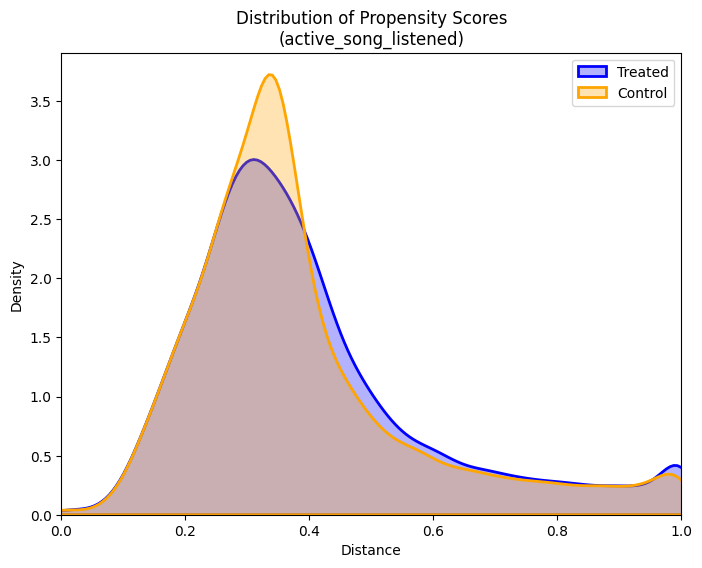

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_songsListened, 'active_song_listened')

### **delta1_songsListened Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_songsListened, 'active_song_listened')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.1004
Control group mean: 0.0402
Average Treatment Effect (ATE): 0.0601

Statistical Test:
Z-test p-value: 0.0000000
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 6.0 percentage point higher conversion rate.


Props Series:


,adopter
active_song_listened,
0,0.040243
1,0.100362


Sems Series:


,adopter
active_song_listened,
0,0.001313
1,0.002008


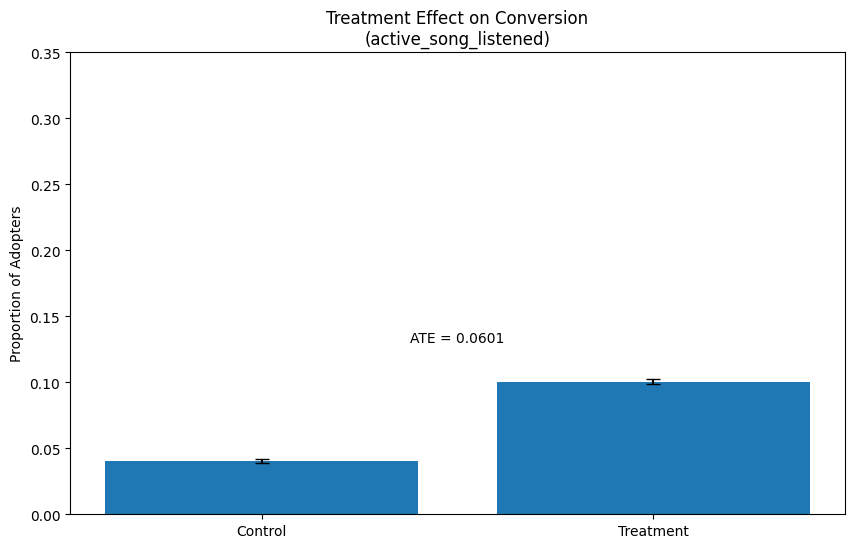

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_songsListened, 'active_song_listened')

## **Treatment: delta1_lovedTracks**

The *delta1_lovedTracks* feature represents a change in the number of new tracks loved from past to current period. If *delta1_lovedTracks* = 3, it means the user loved three more new tracks in the current period compared to the past. If *delta1_lovedTracks* = -3, it means the user loved three less new tracks in the current period compared to the past.

Therefore,

If **delta1** > 0, it represents users who increased their discovery/investment in tracks at High Note.

If **delta1** ≤ 0, it represents users who maintained or reduced their investment in liking tracks.

In [ ]:
# Make a copy of High Note Dataset
high_note_lovedTracks = high_note.copy()

# Create a binary variable
high_note_lovedTracks['active_lovedTracks'] = (high_note_lovedTracks['delta1_lovedTracks'] > 0).astype(int)

# Drop the 'active_lovedTracks' variable and store into hn_songsListened_match
# This will be used for the matching process
hn_lovedTracks_match = high_note_lovedTracks.drop('delta1_lovedTracks', axis=1)

# Drop both the 'active_lovedTracks' variable and 'adopter' variable, store into hn_songsListened
# This is used for preliminary training and AUC inspection
hn_lovedTracks = high_note_lovedTracks.drop(['delta1_lovedTracks', 'adopter'], axis=1)

# Split Treatment from data
lovedTracks_data = hn_lovedTracks.drop('active_lovedTracks', axis=1)
lovedTracks_treatment = hn_lovedTracks['active_lovedTracks']

In [ ]:
# Train the LR model and inspect the AUC
propensity_model_auc(lovedTracks_data, lovedTracks_treatment)

'AUC: 0.83'

In [ ]:
%%R -i hn_lovedTracks_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_lovedTracks ~ . - adopter,
                      data = hn_lovedTracks_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_lovedTracks = match.data(matchprocess)
write.csv(matched_lovedTracks,"matched_lovedTracks.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_lovedTracks ~ . - adopter, data = hn_lovedTracks_match, 
    method = "nearest", distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.4180        0.1195          0.9854
male                                0.6981        0.7320         -0.0738
friend_cnt                         30.2523        8.5333          0.2871
avg_friend_age                     23.6726       24.5268         -0.1808
avg_friend_male                     0.6253        0.6377         -0.0493
friend_country_cnt                  5.6421        2.2023          0.4298
subscriber_friend_cnt               0.9009        0.2187          0.2505
songsListened                   26062.3295    10155.0966          0.4488
lovedTracks                       261.1368       40.1297          0.3835
po

After matching, there were 14165 pairs available, with an average propensity score being 0.31 for treatment and 0.30 for control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_lovedTracks = pd.read_csv('matched_lovedTracks.csv')
matched_lovedTracks.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country,active_lovedTracks,distance,weights,subclass
0,0,20,30.285714,0.736842,14,1,8414.0,348,0,1,...,0,0,0,59,1,0,1,0.825337,1,1
1,1,1,24.363070,1.000000,1,0,187.0,0,0,0,...,0,0,0,52,0,0,0,0.052806,1,12570
2,0,1,16.000000,0.378899,1,0,13350.0,6,0,0,...,0,1,0,7,0,0,0,0.281281,1,4350
3,0,28,22.947368,0.500000,7,1,1357.0,32,0,0,...,0,0,0,25,0,0,1,0.206571,1,2
4,1,4,24.000000,0.000000,1,0,1621.0,636,0,1,...,0,0,0,46,0,0,0,0.564572,1,14142


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1, albeit a right-skewed distribution and most values being at the lower range. This indicates that our study encompasses all possible combinations of the observed covariates, allowing for generalizability of our treatment effect estimates across the full range of observed characteristics.

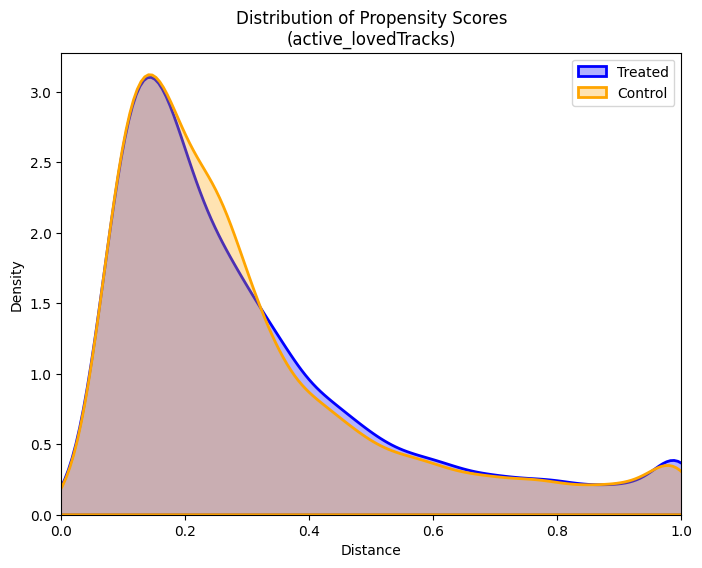

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_lovedTracks, 'active_lovedTracks')

### **delta1_lovedTracks Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_lovedTracks, 'active_lovedTracks')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.1665
Control group mean: 0.0876
Average Treatment Effect (ATE): 0.0789

Statistical Test:
Z-test p-value: 0.0000000
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 7.9 percentage point higher conversion rate.


Props Series:


,adopter
active_lovedTracks,
0,0.087610
1,0.166537


Sems Series:


,adopter
active_lovedTracks,
0,0.002376
1,0.003130


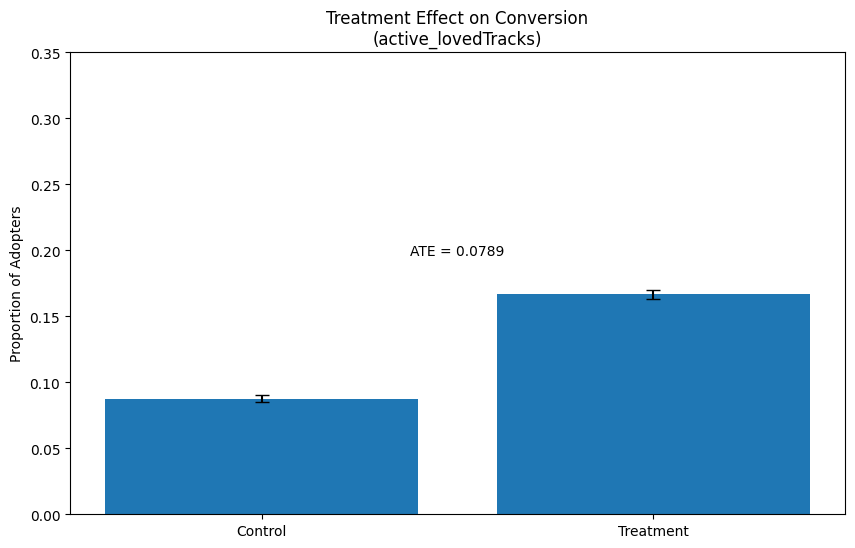

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_lovedTracks, 'active_lovedTracks')

## **Treatment: delta1_friend_cnt**


The *delta1_friend_cnt* feature represents change in the number of new friends from past to current period.
If *delta1_friend_cnt* = 3, it means the user made three more new friends in the current period compared to the past. If *delta1_friend_cnt* = -3, it means the user made three less new friends in the current period compared to the past.

Therefore,

If **delta1** > 0, it represents users who increased their social network growth at High Note.

If **delta1** ≤ 0, it represents users with same or declining social engagement on the platform.  

In [ ]:
# Make a copy of High Note Dataset
high_note_friend_cnt = high_note.copy()

# Create a binary variable
high_note_friend_cnt['active_friend_cnt'] = (high_note_friend_cnt['delta1_friend_cnt'] > 0).astype(int)

# Drop the 'delta1_friend_cnt' variable and store into hn_friend_cnt_match
# This will be used for the matching process
hn_friend_cnt_match = high_note_friend_cnt.drop('delta1_friend_cnt', axis=1)

# Drop both the 'delta1_friend_cnt' variable and 'adopter' variable, store into hn_friend_cnt
# This is used for preliminary training and AUC inspection
hn_friend_cnt = high_note_friend_cnt.drop(['delta1_friend_cnt', 'adopter'], axis=1)

# Split Treatment from data
friend_cnt_data = hn_friend_cnt.drop('active_friend_cnt', axis=1)
friend_cnt_treatment = hn_friend_cnt['active_friend_cnt']

In [ ]:
# Train the LR model and inspect the AUC
propensity_model_auc(friend_cnt_data, friend_cnt_treatment)

'AUC: 0.8'

In [ ]:
%%R -i hn_friend_cnt_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_friend_cnt ~ . - adopter,
                      data = hn_friend_cnt_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_friend_cnt = match.data(matchprocess)
write.csv(matched_friend_cnt,"matched_friend_cnt.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_friend_cnt ~ . - adopter, data = hn_friend_cnt_match, 
    method = "nearest", distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.4591        0.0791          1.0729
male                                0.6370        0.7393         -0.2127
friend_cnt                         44.5584        7.5041          0.3635
avg_friend_age                     23.2156       24.5518         -0.2943
avg_friend_male                     0.6124        0.6389         -0.1117
friend_country_cnt                  7.6233        2.0809          0.6112
subscriber_friend_cnt               1.3337        0.1888          0.2644
songsListened                   28867.5177    10523.4241          0.4940
lovedTracks                       194.3285       60.7173          0.2343
post

After matching, there were 9273 pairs available, with an average propensity score being 0.27 for both treatment and control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_friend_cnt = pd.read_csv('matched_friend_cnt.csv')
matched_friend_cnt.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country,active_friend_cnt,distance,weights,subclass
0,1,3,30.500000,0.333333,1,0,1943.0,0,0,0,...,0,0,0,34,0,0,1,0.032643,1,1
1,0,1,16.000000,0.378899,1,0,13350.0,6,0,0,...,0,1,0,7,0,0,0,0.187980,1,6764
2,0,28,22.947368,0.500000,7,1,1357.0,32,0,0,...,0,0,0,25,0,0,1,0.265766,1,2
3,0,65,22.283019,0.913793,9,0,89984.0,20,2,0,...,0,0,0,67,0,0,0,0.228342,1,1613
4,1,57,23.636364,0.520833,14,1,99877.0,125,89,1,...,0,0,0,71,0,0,0,0.246559,1,6894


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1, albeit a right-skewed distribution and most values being at the lower range. This indicates that our study encompasses all possible combinations of the observed covariates, allowing for generalizability of our treatment effect estimates across the full range of observed characteristics.

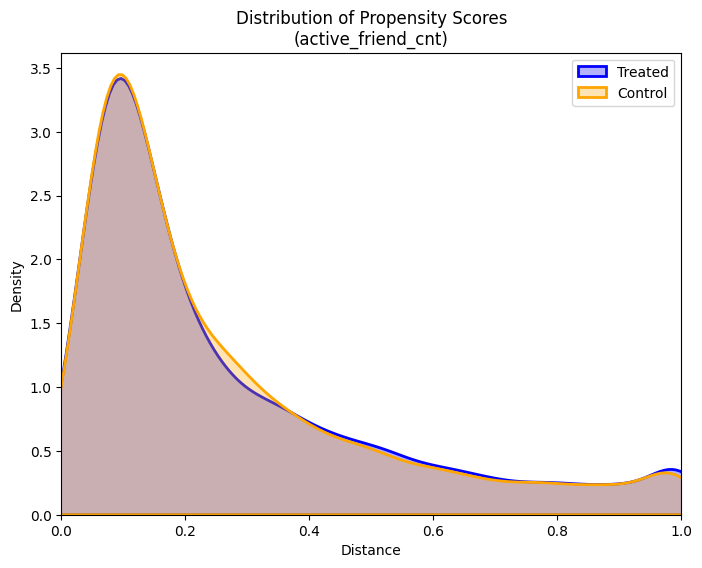

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_friend_cnt, 'active_friend_cnt')

### **delta1_friend_cnt Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_friend_cnt, 'active_friend_cnt')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.1529
Control group mean: 0.0905
Average Treatment Effect (ATE): 0.0624

Statistical Test:
Z-test p-value: 0.0000000
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 6.2 percentage point higher conversion rate.


Props Series:


,adopter
active_friend_cnt,
0,0.090478
1,0.152917


Sems Series:


,adopter
active_friend_cnt,
0,0.002979
1,0.003738


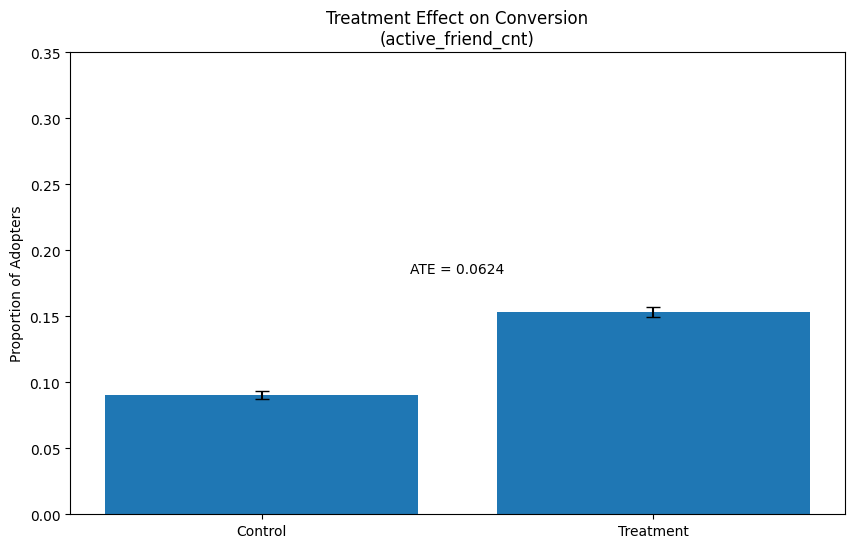

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_friend_cnt, 'active_friend_cnt')

## **Treatment: delta1_friend_country_cnt**


The *delta1_friend_country_cnt* feature represents change in the number of different countries of the users' new friends from past to current period.
If *delta1_friend_country_cnt* = 3, it means the user's new friends are from three more differnet countries compared to the past. If *delta1_friend_cnt* = -3, it means the user's new friends are from three less differnet countries compared to the past.

Therefore,

If **delta1** > 0, it represents users who increased their international friend network diversity, indicating growing global connectivity.

If **delta1** ≤ 0, it represents users who maintained or decreased their international friend network diversity, indicating more localized social connections.

In [ ]:
# Make a copy of High Note Dataset
high_note_friend_country_cnt = high_note.copy()

# Create a binary variable
high_note_friend_country_cnt['active_friend_country_cnt'] = (high_note_friend_country_cnt['delta1_friend_country_cnt'] > 0).astype(int)

# Drop the 'delta1_friend_country_cnt' variable and store into hn_friend_country_cnt_match
# This will be used for the matching process
hn_friend_country_cnt_match = high_note_friend_country_cnt.drop('delta1_friend_country_cnt', axis=1)

# Drop both the 'delta1_friend_country_cnt' variable and 'adopter' variable, store into hn_friend_country_cnt
# This is used for preliminary training and AUC inspection
hn_friend_country_cnt = high_note_friend_country_cnt.drop(['delta1_friend_country_cnt', 'adopter'], axis=1)

# Split Treatment from data
friend_country_cnt_data = hn_friend_country_cnt.drop('active_friend_country_cnt', axis=1)
friend_country_cnt_treatment = hn_friend_country_cnt['active_friend_country_cnt']

In [ ]:
# Train the LR model and inspect the AUC
propensity_model_auc(friend_country_cnt_data, friend_country_cnt_treatment)

'AUC: 0.69'

In [ ]:
%%R -i hn_friend_country_cnt_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_friend_country_cnt ~ . - adopter,
                      data = hn_friend_country_cnt_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_friend_country_cnt = match.data(matchprocess)
write.csv(matched_friend_country_cnt,"matched_friend_country_cnt.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_friend_country_cnt ~ . - adopter, data = hn_friend_country_cnt_match, 
    method = "nearest", distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.3416        0.0419          0.8727
male                                0.6050        0.7340         -0.2639
friend_cnt                         53.7421        9.5891          0.2913
avg_friend_age                     23.2252       24.4549         -0.2654
avg_friend_male                     0.6070        0.6374         -0.1231
friend_country_cnt                  9.6045        2.3541          0.7004
subscriber_friend_cnt               1.6604        0.2504          0.2017
songsListened                   28109.7296    11893.2953          0.4498
lovedTracks                       210.6286       69.3058     

After matching, there were 5477 pairs available, with an average propensity score being 0.24 for both treatment and control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_friend_country_cnt = pd.read_csv('matched_friend_country_cnt.csv')
matched_friend_country_cnt.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country,active_friend_country_cnt,distance,weights,subclass
0,0,20,30.285714,0.736842,14,1,8414.0,348,0,1,...,0,0,0,59,1,0,1,0.894695,1,1
1,0,28,22.947368,0.500000,7,1,1357.0,32,0,0,...,0,0,0,25,0,0,0,0.158385,1,4361
2,0,4,21.333333,0.333333,4,0,2.0,2,0,1,...,0,0,0,16,0,0,0,0.059557,1,2133
3,0,18,23.538462,0.687500,11,1,57.0,15,4,1,...,0,0,0,30,0,0,0,0.117909,1,1904
4,1,1,23.584519,1.000000,1,0,1430.0,4,0,1,...,0,0,0,20,0,0,0,0.027049,1,731


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1, albeit a right-skewed distribution and most values being at the lower range. This indicates that our study encompasses all possible combinations of the observed covariates, allowing for generalizability of our treatment effect estimates across the full range of observed characteristics.

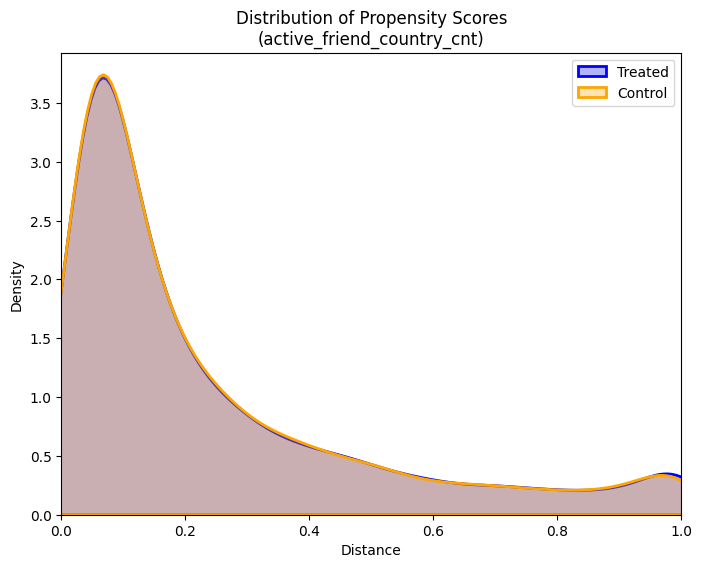

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_friend_country_cnt, 'active_friend_country_cnt')

### **delta1_friend_country Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_friend_country_cnt, 'active_friend_country_cnt')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.1663
Control group mean: 0.1404
Average Treatment Effect (ATE): 0.0259

Statistical Test:
Z-test p-value: 0.0001664
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 2.6 percentage point higher conversion rate.


Props Series:


,adopter
active_friend_country_cnt,
0,0.140405
1,0.166332


Sems Series:


,adopter
active_friend_country_cnt,
0,0.004695
1,0.005032


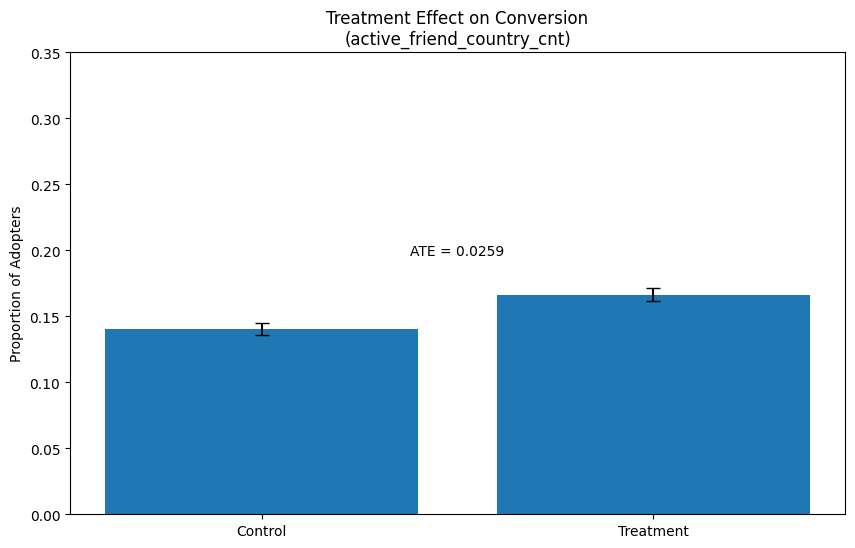

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_friend_country_cnt, 'active_friend_country_cnt')

## **Treatment: delta1_subscriber_friend_cnt**


The *delta1_subscriber_friend_cnt* feature represents change in the number of new friends who are **premium subscribers** from past to current period. If *delta1_subscriber_friend_cnt* = 3, it means the user made three more new friends who are subscribers in the current period compared to the past. If *delta1_subscriber_friend_cnt* = -3, it means the user made three less new friends who are subscribers in the current period compared to the past.


Therefore,

If **delta1** > 0, it represents users who increased their connections with premium subscribers, indicating growing exposure to premium-user network.

If **delta1** ≤ 0, it represents users who maintained or decreased their rate of adding premium subscriber friends, indicating reduced rate of connection with premium users.

In [ ]:
# Make a copy of High Note Dataset
high_note_subscriber_friend_cnt = high_note.copy()

# Create a binary variable
high_note_subscriber_friend_cnt['active_subscriber_friend_cnt'] = (high_note_subscriber_friend_cnt['delta1_subscriber_friend_cnt'] > 0).astype(int)

# Drop the 'delta1_subscriber_friend_cnt' variable and store into hn_subscriber_friend_cnt_match
# This will be used for the matching process
hn_subscriber_friend_cnt_match = high_note_subscriber_friend_cnt.drop('delta1_subscriber_friend_cnt', axis=1)

# Drop both the 'delta1_subscriber_friend_cnt' variable and 'adopter' variable, store into hn_subscriber_friend_cnt
# This is used for preliminary training and AUC inspection
hn_subscriber_friend_cnt = high_note_subscriber_friend_cnt.drop(['delta1_subscriber_friend_cnt', 'adopter'], axis=1)

# Split Treatment from data
subscriber_friend_cnt_data = hn_subscriber_friend_cnt.drop('active_subscriber_friend_cnt', axis=1)
subscriber_friend_cnt_treatment = hn_subscriber_friend_cnt['active_subscriber_friend_cnt']

The initial logistic regression model for predicting treatment assignment of *delta1_subscriber_friend_cnt* yielded an AUC close to 0.5, indicating suboptimal discrimination of the treatment mechanism and risk of unreliable propensity score estimation. A poor model fit could lead to biased estimates and inadequate balance in subsequent matching procedures. To address this model fit concern, the regularization penalty was adjusted downward, allowing for more accurate estimation of propensity scores that better reflect the true treatment assignment mechanism based on units' characteristics.

In [ ]:
# Train the LR model and inspect the AUC
lasso_params = {
        'random_state': 42,
        'penalty': 'l1',    # LASSO penalty
        'solver': 'liblinear',
        'C': 0.001
    }
propensity_model_auc(subscriber_friend_cnt_data, subscriber_friend_cnt_treatment, **lasso_params)

'AUC: 0.79'

In [ ]:
%%R -i hn_subscriber_friend_cnt_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_subscriber_friend_cnt ~ . - adopter,
                      data = hn_subscriber_friend_cnt_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_subscriber_friend_cnt = match.data(matchprocess)
write.csv(matched_subscriber_friend_cnt,"matched_subscriber_friend_cnt.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_subscriber_friend_cnt ~ . - adopter, 
    data = hn_subscriber_friend_cnt_match, method = "nearest", 
    distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                          Means Treated Means Control Std. Mean Diff.
distance                         0.1638        0.0348          0.5724
male                             0.6311        0.7302         -0.2053
friend_cnt                      52.7335       10.5485          0.4195
avg_friend_age                  24.9200       24.3589          0.1153
avg_friend_male                  0.6368        0.6355          0.0054
friend_country_cnt               9.0888        2.5262          0.6521
subscriber_friend_cnt            2.7440        0.2347          0.5882
songsListened                30433.7702    12133.6869          0.4255
lovedTracks                    229.7695       71.4470          0.1912
posts  

After matching, there were 4254 pairs available, with an average propensity score being 0.16 for both treatment and control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_subscriber_friend_cnt = pd.read_csv('matched_subscriber_friend_cnt.csv')
matched_subscriber_friend_cnt.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_playlists,delta1_shouts,adopter,tenure,good_country,delta1_good_country,active_subscriber_friend_cnt,distance,weights,subclass
0,0,28,22.947368,0.500000,7,1,1357.0,32,0,0,...,0,0,0,25,0,0,1,0.048544,1,1
1,1,57,23.636364,0.520833,14,1,99877.0,125,89,1,...,0,0,0,71,0,0,0,0.078488,1,2275
2,0,18,23.538462,0.687500,11,1,57.0,15,4,1,...,0,0,0,30,0,0,0,0.069537,1,2801
3,1,2,31.000000,0.000000,1,1,80214.0,16,0,1,...,0,0,0,60,0,0,0,0.054655,1,4017
4,1,13,25.333333,0.400000,2,1,3372.0,9,0,0,...,0,0,0,51,0,0,1,0.031385,1,2


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1, albeit a right-skewed distribution and most values being at the lower range. This indicates that our study encompasses all possible combinations of the observed covariates, allowing for generalizability of our treatment effect estimates across the full range of observed characteristics.

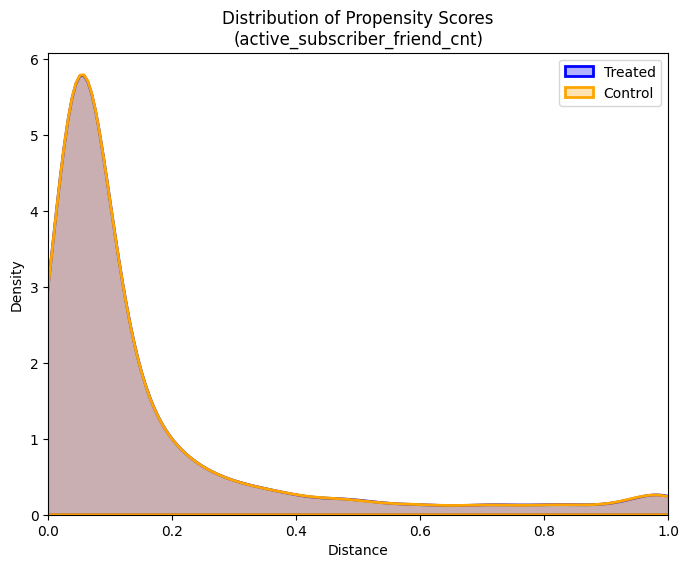

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_subscriber_friend_cnt, 'active_subscriber_friend_cnt')

### **delta1_subscriber_friend_cnt Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_subscriber_friend_cnt, 'active_subscriber_friend_cnt')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.2047
Control group mean: 0.1749
Average Treatment Effect (ATE): 0.0299

Statistical Test:
Z-test p-value: 0.0004465
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 3.0 percentage point higher conversion rate.


Props Series:


,adopter
active_subscriber_friend_cnt,
0,0.174894
1,0.204748


Sems Series:


,adopter
active_subscriber_friend_cnt,
0,0.005825
1,0.006187


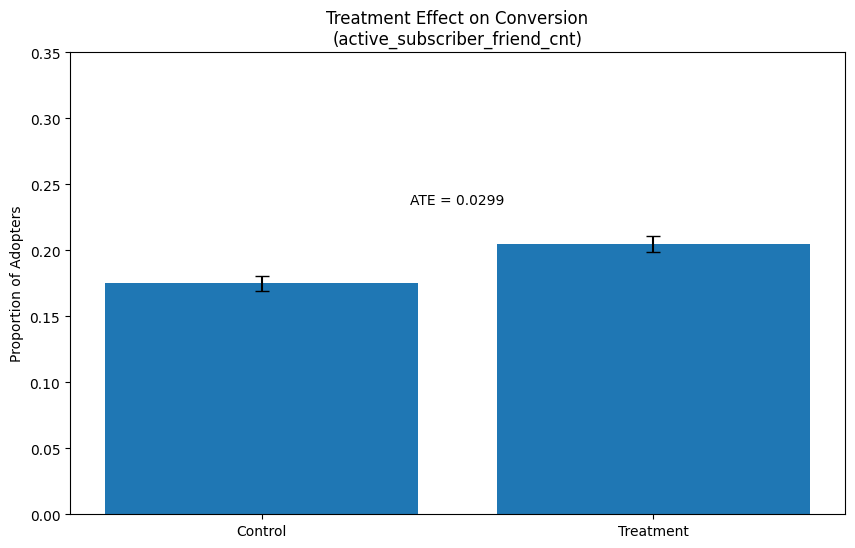

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_subscriber_friend_cnt, 'active_subscriber_friend_cnt')

## **Treatment: delta1_shouts**


The *delta1_shouts* feature represents change in the number of new shouts received from others from past to current period. If *delta1_shouts* = 3, it means the user received three more new shouts in the current period compared to the past. If *delta1_shouts* = -3, it means the user received three less new shouts in the current period compared to the past.

Therefore,

If **delta1** > 0, it represents users who received more social interactions at High Note compared to the past period, indicating growing social visibility and engagement from others and implying that the user is an active community member.

If **delta1** ≤ 0, it represents same or declining community engagement and visibility.

In [ ]:
# Make a copy of High Note Dataset
high_note_shouts = high_note.copy()

# Create a binary variable
high_note_shouts['active_shouts'] = (high_note_shouts['delta1_shouts'] > 0).astype(int)

# Drop the 'delta1_shouts' variable and store into hn_shouts_match
# This will be used for the matching process
hn_shouts_match = high_note_shouts.drop('delta1_shouts', axis=1)

# Drop both the 'delta1_shouts' variable and 'adopter' variable, store into hn_shouts
# This is used for preliminary training and AUC inspection
hn_shouts = high_note_shouts.drop(['delta1_shouts', 'adopter'], axis=1)

# Split Treatment from data
shouts_data = hn_shouts.drop('active_shouts', axis=1)
shouts_treatment = hn_shouts['active_shouts']

In [ ]:
# Train the LR model and inspect the AUC
propensity_model_auc(shouts_data, shouts_treatment)

'AUC: 0.81'

In [ ]:
%%R -i hn_shouts_match
library(MatchIt)
library(glmnet)

# Perform Propensity Score Matching
matchprocess = matchit(active_shouts ~ . - adopter,
                      data = hn_shouts_match,
                      method = "nearest",
                      distance = "glm",
                      link = "logit",
                      caliper = 0.1,
                      ratio = 1,
                      distance.options = list(
                        alpha = 1,
                        lambda = 100000
                      ))

# Store matched data
matched_shouts = match.data(matchprocess)
write.csv(matched_shouts,"matched_shouts.csv", row.names=FALSE)

# Show matching result
summary(matchprocess)


Call:
matchit(formula = active_shouts ~ . - adopter, data = hn_shouts_match, 
    method = "nearest", distance = "glm", link = "logit", distance.options = list(alpha = 1, 
        lambda = 1e+05), caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.3604        0.0520          0.9184
male                                0.6082        0.7359         -0.2615
friend_cnt                         61.2960        8.2434          0.3569
avg_friend_age                     22.8545       24.5054         -0.3747
avg_friend_male                     0.6093        0.6377         -0.1229
friend_country_cnt                  9.8335        2.2153          0.6914
subscriber_friend_cnt               1.8529        0.2114          0.2406
songsListened                   33798.5845    11162.1447          0.5477
lovedTracks                       245.0530       64.1657          0.3458
posts       

After matching, there were 6646 pairs available, with an average propensity score being 0.25 for both treatment and control. Furthermore, the mean values beween the two groups were similar across features, indicating good balance.

In [ ]:
# This is the result table of the matching process
matched_shouts = pd.read_csv('matched_shouts.csv')
matched_shouts.head()

,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,...,delta1_posts,delta1_playlists,adopter,tenure,good_country,delta1_good_country,active_shouts,distance,weights,subclass
0,0,20,30.285714,0.736842,14,1,8414.0,348,0,1,...,0,0,0,59,1,0,0,0.556653,1,3377
1,0,1,16.000000,0.378899,1,0,13350.0,6,0,0,...,0,0,0,7,0,0,1,0.114588,1,1
2,0,4,21.333333,0.333333,4,0,2.0,2,0,1,...,0,0,0,16,0,0,0,0.067840,1,893
3,1,1,23.000000,1.000000,1,0,665.0,2,0,0,...,0,0,0,22,0,0,0,0.034081,1,4667
4,0,3,17.500000,0.333333,2,0,17.0,5,0,0,...,0,0,0,33,0,0,0,0.053929,1,256


We observed that there is sufficient overlap of the propensity score distributions between treatment and control. The plot further shows that the propensity score pairs exist for all strata between 0 and 1, albeit a right-skewed distribution and most values being at the lower range. This indicates that our study encompasses all possible combinations of the observed covariates, allowing for generalizability of our treatment effect estimates across the full range of observed characteristics.

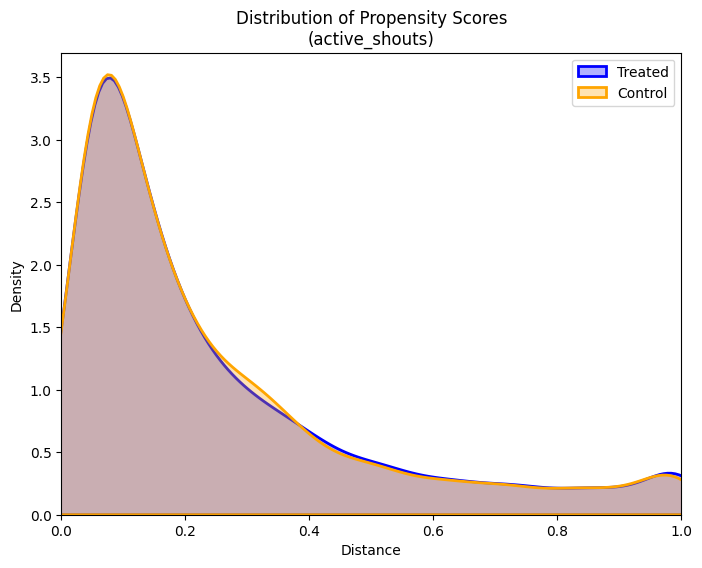

In [ ]:
# Compare the propensity score distribution for treatment and control groups
plot_propensity_distribution(matched_shouts, 'active_shouts')

### **delta1_shouts Treatment Effect**

The assessment below shows the results of the two-proportion z-test between the treatment and control.

In [ ]:
# Assess the treatment effect
results = analyze_treatment_effect(matched_shouts, 'active_shouts')


Treatment Effect Analysis:
--------------------------
Treatment group mean: 0.1621
Control group mean: 0.1177
Average Treatment Effect (ATE): 0.0444

Statistical Test:
Z-test p-value: 0.0000000
There is a significant difference between the treatment and control groups (p < 0.05).
The treatment group has a 4.4 percentage point higher conversion rate.


Props Series:


,adopter
active_shouts,
0,0.117665
1,0.162052


Sems Series:


,adopter
active_shouts,
0,0.003953
1,0.004521


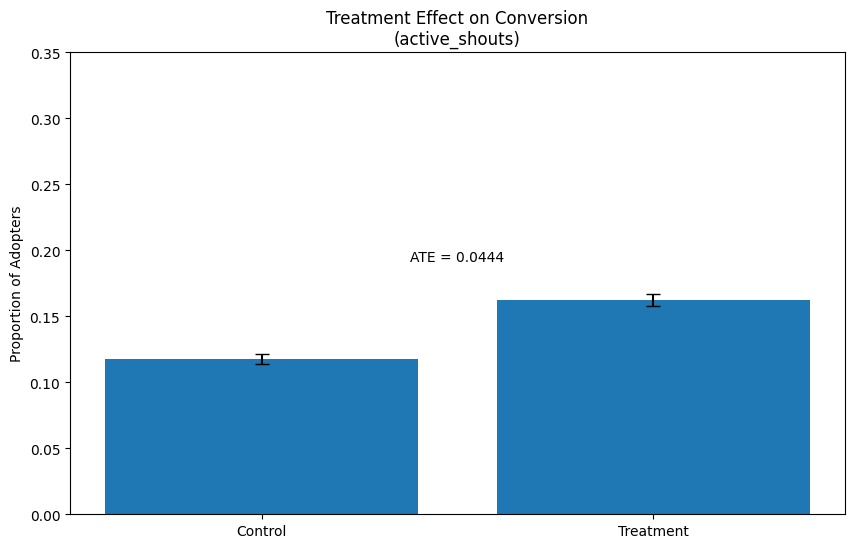

In [ ]:
# View the treatment effect
plot_treatment_effect(matched_shouts, 'active_shouts')

# **High Note's User Conversion Strategy**

This section summarizes the strategies High Note can consider in order to nudge its free tier users towards a premium subscription, based on the analysis results in the previous sections.




### **1. Encourage Users to Listen to More Songs**


Our first recommendation is to drive increased song engagement among users. Data analysis has demonstrated that premium subscribers listen to more songs on average compared to free users, with evidence showing that increasing song engagement directly drives a 6% increase
in premium subscription rates. Users who engage more with music content are likely to develop
stronger platform loyalty, and increased listening time naturally extends their interaction with the
app. High Note can implement this by introducing listening milestones and corresponding benefits, as well as personalized
recommendations generated through recommendation algorithms to increase exposure to users' preferred song types. These
enhancements can increase the users' likeability of the platform, deepening their desire for premium benefits.

### **2. Nudge Users to Click the “Love” Button**

Our second recommendation is to increase user engagement through the "love" track feature.
Analysis reveals causal evidence that increasing the “loved” track drives an 7.9% increase in
conversion rate. When users actively "love" tracks, they signal their preferences, enabling the
platform to deliver more tailored services and personalized playlists. This creates a
highly engaging and satisfying user experience, increasing the likelihood of users finding value
in premium features and ultimately leading to higher subscription rates. To implement this, High
Note can allow public sharing of users' favorite tracks as well as creation of personalized playlists based on their loved
songs. Notifications and reminders to "love" tracks users have frequently listened to can further reinforce user behavior, while
integration with social media platforms can allow users to share their preferences, increasing
platform visibility and engagement.

### **3. Encourage Users to Make More Friends**

Enhancing social connectivity emerges as our third key recommendation for driving subscription
growth. Data analysis revealed a notable difference in the number of friends between free users and subscribers, with causal analysis demonstrating that expanding the social network
leads to a 6.2% higher conversion rate. This suggests that a robust social
network increases platform stickiness and creates a sense of community. These social
connections ultimately motivate users to explore and invest in premium features that enables higher community engagement. High Note can implement friend-suggestion systems that leverage behavioral and demographic data,
fostering connections among users with similar musical tastes. Collaborative playlists and
shared listening experiences can further solidify these connections, and additionally providing referral programs incentivizing users to invite friends with rewards such as premium trial periods can amplify social growth.

### **4. Facilitate Globally “Diverse” Friends**

Our fourth recommendation focuses on promoting **international** friend connections. Analysis
demonstrates that diversity in friends’ nationalities positively influences premium subscription
rates, with evidence establishing a causal link between international network expansion and a
2.6% higher conversion rate. Connecting with friends from diverse countries exposes users to
new and unique content, including trending songs and playlists from different regions. This
diversity enriches the user experience and keeps the platform engaging, encouraging users to
invest in premium features to further explore global content. High Note can implement this by
introducing features such as "Discover International Friends," where users are encouraged to
connect with others from different countries through shared music preferences. This can be
complemented by curated global playlists, introducing users to music from different cultures.
Mobile targeting techniques such as geofencing can further encourage cross-border
engagement by offering location-specific music promotions.

### **5. Friends Subscribe, Users Subscribe**


Our fifth recommendation emphasizes connecting users with **premium subscribers**. Analysis
reveals that increasing friendships with premium subscribers causally impacts conversion
rates, with evidence showing that expanding their network of subscriber friends leads to a 3%
higher conversion rate. This peer influence metric demonstrates the power of social proof in
driving premium adoptions. When users connect with premium subscribers, they gain direct
exposure to subscription benefits through their peers' experiences and usage patterns. This
organic showcase of premium features, combined with the desire to fully participate in their
social circle's activities, creates a natural pathway to subscription conversion. The company can
create a "Premium Circle" feature that highlights which friends are premium subscribers and
showcases the benefits they enjoy.

### **6. More “Shouts,” More User Interactions**

Our final recommendation centers on increasing user engagement through the "shouts"
messaging feature. Data analysis revealed a clear difference in the number of shouts between free users and subscribers, with evidence verifying that receiving more messages leads to
a 4.4% higher conversion rate. Active messaging interaction creates a more dynamic platform
experience and strengthens community connections. As users become more integrated into the
platform's social fabric through these direct communications, they might be motivated to explore
and adopt premium social features for enhanced interactive experience. To boost "shouts"
activity, the company can implement features like conversation starters or automated prompts to
encourage users to send messages.

# **Conclusion**

Through data-driven analysis, our group has identified six actionable strategies to boost
premium subscription rates on High Note, focusing on increasing song engagement,
encouraging interactions through features like "love" tracks and "shouts," and strengthening
social connectivity with diverse and premium-subscriber friends. Each strategy is supported by
causal insights and implementation plans. By adopting these strategies, High Note can
effectively convert more free users into loyal premium subscribers and strengthen its position in
the market.